# Web Server Log Analysis with Apache Spark
 
This lab will demonstrate how easy it is to perform web server log analysis with Apache Spark.

Server log analysis is an ideal use case for Spark.  It's a very large, common data source and contains a rich set of information. Spark allows you to store your logs in files on disk cheaply, while still providing a quick and simple way to perform data analysis on them. Log data comes from many sources, such as web, file, and compute servers, application logs, user-generated content, and can be used for monitoring servers, improving business and customer intelligence, building recommendation systems, fraud detection, and much more.

This lab is broken up into sections with bite-sized examples for demonstrating Spark functionality for log processing. For each problem, you should start by thinking about the algorithm that you will use to *efficiently* process the log in a parallel, distributed manner. This means using the various built in [pyspark functions](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#module-pyspark.sql.functions) along with some [user defined functions](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.udf).
 
This lab consists of 4 parts:

1. Apache Web Server Log file format
2. Sample Analyses on the Web Server Log File
3. Analyzing Web Server Log File
4. Exploring 404 Response Codes

## (1) Apache Web Server Log file format

The log files that we use for this lab are in the [Apache Common Log Format (CLF)](http://httpd.apache.org/docs/1.3/logs.html#common). The log file entries produced in CLF will look something like this:
`127.0.0.1 - - [01/Aug/1995:00:00:01 -0400] "GET /images/launch-logo.gif HTTP/1.0" 200 1839`
 
Each part of this log entry is described below.

* `127.0.0.1` - This is the IP address (or host name, if available) of the client (remote host) which made the request to the server.
 
* `-` - The "hyphen" in the output indicates that the requested piece of information (user identity from remote machine) is not available.
 
* `-` - The "hyphen" in the output indicates that the requested piece of information (user identity from local logon) is not available.

* `[01/Aug/1995:00:00:01 -0400]` - The time that the server finished processing the request. The format is:
`[day/month/year:hour:minute:second timezone]`

  * day = 2 digits
  * month = 3 letters
  * year = 4 digits
  * hour = 2 digits
  * minute = 2 digits
  * second = 2 digits
  * zone = (+|-) 4 digits
 
* `"GET /images/launch-logo.gif HTTP/1.0"` - This is the first line of the request string from the client. It consists of a three components:

  * the request method (e.g., `GET`, `POST`, etc.)
  * the endpoint (a [Uniform Resource Identifier](http://en.wikipedia.org/wiki/Uniform_resource_identifier))
  * the client protocol and version

* `200` - This is the status code that the server sends back to the client. This information is very valuable, because it reveals whether the request resulted in a successful response (codes beginning in 2), a redirection (codes beginning in 3), an error caused by the client (codes beginning in 4), or an error in the server (codes beginning in 5). The full list of possible status codes can be found in the HTTP specification ([RFC 2616](https://www.ietf.org/rfc/rfc2616.txt) section 10).
 
* `1839` - The last entry indicates the size of the object returned to the client, not including the response headers. If no content was returned to the client, this value will be "-" (or sometimes 0).
 
Note that log files contain information supplied directly by the client, without escaping. Therefore, it is possible for malicious clients to insert control-characters in the log files, *so care must be taken in dealing with raw logs.*

For this lab, we will use a data set from NASA Kennedy Space Center WWW server in Florida. The full data set is freely available (http://ita.ee.lbl.gov/html/contrib/NASA-HTTP.html) and contains two months of HTTP requests. We are using a subset that only contains several days worth of requests.

## (1a) Parse a Log Timestamp

We must first write a function that can parse an Apache Logs format timestamp. For this you should use `datetime.strptime()`. Passing a pattern string formatted according to [the documentation](https://docs.python.org/3/library/datetime.html#strftime-strptime-behavior), this can be used to build a `datetime` object from a string.

For example:

In [1]:
from datetime import datetime

pattern = '%d/%m/%y %H:%M'
timestamp = '17/02/17 14:05'

datetime.strptime(timestamp, pattern)

datetime.datetime(2017, 2, 17, 14, 5)

Below we use this to define a function that parses an Apache log format timestamp to a `datetime` object (or `None` in the case of an invalid timestamp). Complete the time pattern to correctly parse Apache timestamps.

In [2]:
APACHE_TIME_PATTERN ='%d/%b/%Y:%H:%M:%S %z'

def parse_apache_time(string):
    """Parse an Apache log formatted date string.
    
    Parameters
    ----------
    string : str
        The string to parse
        
    Returns
    -------
    datetime or None
    """
    try:
        return datetime.strptime(string, APACHE_TIME_PATTERN)
    except ValueError:
        return None

parsed_time = parse_apache_time('01/Aug/1995:00:00:08 -0400')
print(parsed_time)

1995-08-01 00:00:08-04:00


In [3]:
from test_helper import Test
from datetime import timedelta, timezone
utc_minus_4 = timezone(timedelta(hours=-4))
Test.assertEquals(parsed_time,
                  datetime(1995, 8, 1, 0, 0, 8, tzinfo=utc_minus_4),
                 'incorrect parsed_time')

1 test passed.


## (1b) Extract components from log line

Using the CLF as defined above, we write a regular expression pattern to extract the nine fields of the log line. This regular expression should extract 9 'groups' - one for each of:

* Client host (hostname or IP address)
* Remote user identity
* Local user identity
* Timestamp
* Request method
* Endpoint
* Client protocol and version
* Returned HTTP status code
* Returned content size

The function `parse_apache_log_line` applies the regular expression `APACHE_ACCESS_LOG_PATTERN` using the python [`re.search`](https://docs.python.org/3/library/re.html#re.search) method. Execute the cell to test the regular expression on a sample row.

In [4]:
import re
from pprint import pprint

APACHE_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)" (\d{3}) (\S+)'

APACHE_LOG_FIELD_NAMES = [
    'host', 'client_identd', 'user_id', 'date_time', 'method', 'endpoint',
    'protocol', 'response_code', 'content_size'
]
APACHE_ACCESS_LOG_SAMPLE_LINE = 'uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/ksclogo-medium.gif HTTP/1.0" 304 0'


def parse_apache_log_line(logline):
    """Parse a line in the Apache Common Log format.
    
    Parameters
    ----------
    logline : str
        A line of text in the Apache Common Log format
        
    Returns
    -------
    dict or None
        The parsed line
    """
    
    match = re.search(APACHE_ACCESS_LOG_PATTERN, logline)
    
    if match is None:
        return
    
    fields = dict(zip(APACHE_LOG_FIELD_NAMES, match.groups()))

    return fields


pprint(parse_apache_log_line(APACHE_ACCESS_LOG_SAMPLE_LINE))

{'client_identd': '-',
 'content_size': '0',
 'date_time': '01/Aug/1995:00:00:08 -0400',
 'endpoint': '/images/ksclogo-medium.gif',
 'host': 'uplherc.upl.com',
 'method': 'GET',
 'protocol': 'HTTP/1.0',
 'response_code': '304',
 'user_id': '-'}


In [5]:
Test.assertEquals(parse_apache_log_line(APACHE_ACCESS_LOG_SAMPLE_LINE),
                  {'client_identd': '-', 'content_size': '0', 'date_time': '01/Aug/1995:00:00:08 -0400',
                   'endpoint': '/images/ksclogo-medium.gif', 'host': 'uplherc.upl.com', 'method': 'GET',
                   'protocol': 'HTTP/1.0', 'response_code': '304', 'user_id': '-'},
                  'log line incorrectly parsed')

1 test passed.


## (1c) Configuration and Initial RDD Creation

We are ready to specify the input log file and load it into a DataFrame.

Let's start by fetching the data:

In [6]:
!rm -rf apache.access.log.*
!wget https://s3-eu-west-1.amazonaws.com/asi-training-data/spark/apache.access.log.PROJECT

--2017-02-17 12:50:22--  https://s3-eu-west-1.amazonaws.com/asi-training-data/spark/apache.access.log.PROJECT
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.48.172
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.48.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111503503 (106M) [application/octet-stream]
Saving to: ‘apache.access.log.PROJECT’

apache.access.log.P 100%[===================>] 106.34M   101MB/s    in 1.1s    

2017-02-17 12:50:23 (101 MB/s) - ‘apache.access.log.PROJECT’ saved [111503503/111503503]



To create the primary RDD that we'll use in the rest of this lab, we first load the text file using [`spark.read.text()`](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.text).

Next, we use `.select()` on the DataFrame along with some [pyspark functions](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#module-pyspark.sql.functions) and [user defined functions](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.udf) to generate a new DataFrame with the fields parsed into the desired formats.

Finally, we cache the DataFrame in memory since we'll use it throughout this notebook.

In [7]:
APACHE_LOG_FILE = "apache.access.log.PROJECT"

import pyspark.sql.functions as func
from pyspark.sql import types


# A helper to generate a `.select()` entry that applies the access log
# regular expression to the 'line' column and extracts a particular group as a new column
extract_field = lambda group: func.regexp_extract('line', APACHE_ACCESS_LOG_PATTERN, group)

# A helper function to apply parse_apache_time to a column
parse_apache_time_udf = func.udf(parse_apache_time, types.TimestampType())

# A helper function to cast a column to integer type
cast_int = lambda col: col.cast('int')

# A helper function to cast a column to integer type, interpreting '-' as 0
safe_cast_int = lambda col: func.when(col == '-', 0).otherwise(col.cast('int'))
    

def parse_logs():
    """Load and parse the logs.
    
    Returns
    -------
    pyspark.sql.DataFrame
        All the logs
    pyspark.sql.DataFrame
        The correctly parsed logs
    pyspark.sql.DataFrame
        The logs that could not be parsed
    """
    
    # Load the dataset and rename the column to 'line'
    logs = (spark.read.text(APACHE_LOG_FILE)
            .select(func.col('value').alias('line')))
    
    # Parse the fields
    parsed_logs = (logs
                   .select(
                       'line',  # Include the original line column
                       extract_field(1).alias('host'),
                       extract_field(2).alias('client_identd'),
                       extract_field(3).alias('user_id'),
                       parse_apache_time_udf(
                           extract_field(4)
                       ).alias('date_time'),
                       extract_field(5).alias('method'),
                       extract_field(6).alias('endpoint'),
                       extract_field(7).alias('protocol'),
                       cast_int(
                           extract_field(8)
                       ).alias('response_code'),
                       safe_cast_int(
                           extract_field(9)
                       ).alias('content_size')
                   )
                   .cache())
    
    # Filter for correctly parsed logs
    access_logs = parsed_logs.filter(func.length('host') > 0)
    failed_logs = parsed_logs.filter(func.length('host') == 0)
    
    return parsed_logs, access_logs, failed_logs


parsed_logs, access_logs, failed_logs = parse_logs()

print('Total logs:          {}'.format(parsed_logs.count()))
print('Successfully parsed: {}'.format(access_logs.count()))
print('Failed to parse:     {}'.format(failed_logs.count()))

Total logs:          1043177
Successfully parsed: 1043069
Failed to parse:     108


## (1d) Data Cleaning

Notice that there are a number of log lines that failed to parse. Since we included the original line column in the parsed DataFrames, we can inspect the lines we failed to pass with:

In [8]:
print('First 20 failed log lines:')
for row in failed_logs.head(20):
    print(repr(row['line']))

First 20 failed log lines:
'ix-sac6-20.ix.netcom.com - - [08/Aug/1995:14:43:39 -0400] "GET / HTTP/1.0 " 200 7131'
'ix-sac6-20.ix.netcom.com - - [08/Aug/1995:14:43:57 -0400] "GET /images/ksclogo-medium.gif HTTP/1.0 " 200 5866'
'ix-sac6-20.ix.netcom.com - - [08/Aug/1995:14:44:07 -0400] "GET /images/NASA-logosmall.gif HTTP/1.0 " 200 786'
'ix-sac6-20.ix.netcom.com - - [08/Aug/1995:14:44:11 -0400] "GET /images/MOSAIC-logosmall.gif HTTP/1.0 " 200 363'
'ix-sac6-20.ix.netcom.com - - [08/Aug/1995:14:44:13 -0400] "GET /images/USA-logosmall.gif HTTP/1.0 " 200 234'
'ix-sac6-20.ix.netcom.com - - [08/Aug/1995:14:44:15 -0400] "GET /images/WORLD-logosmall.gif HTTP/1.0 " 200 669'
'ix-sac6-20.ix.netcom.com - - [08/Aug/1995:14:44:31 -0400] "GET /shuttle/countdown/ HTTP/1.0 " 200 4673'
'ix-sac6-20.ix.netcom.com - - [08/Aug/1995:14:44:41 -0400] "GET /shuttle/missions/sts-69/count69.gif HTTP/1.0 " 200 46053'
'ix-sac6-20.ix.netcom.com - - [08/Aug/1995:14:45:34 -0400] "GET /images/KSC-logosmall.gif HTTP/1.0 "

Examine the sample of invalid lines and compare them to the correctly parsed line. Based on your observations, alter the `APACHE_ACCESS_LOG_PATTERN` regular expression below so that the failed lines will correctly parse, and execute the cell below to rerun `parse_logs()`.
 
If you not familar with Python regular expression [`search` function](https://docs.python.org/3/library/re.html#regular-expression-objects), now would be a good time to check up on the [documentation](https://developers.google.com/edu/python/regular-expressions). One tip that might be useful is to use an online tester like http://pythex.org or http://www.pythonregex.com. To use it, copy and paste the regular expression string below (located between the single quotes ') and test it against one of the 'Invalid logline' above.

In [9]:
# TODO: Replace <FILL IN> with appropriate code

# This was originally '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)" (\d{3}) (\S+)'
APACHE_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)\s*" (\d{3}) (\S+)'

parsed_logs, access_logs, failed_logs = parse_logs()

print('Total logs:          {}'.format(parsed_logs.count()))
print('Successfully parsed: {}'.format(access_logs.count()))
print('Failed to parse:     {}'.format(failed_logs.count()))

Total logs:          1043177
Successfully parsed: 1043177
Failed to parse:     0


In [10]:
Test.assertEquals(failed_logs.count(), 0, 'incorrect failed_logs.count()')
Test.assertEquals(parsed_logs.count(), 1043177 , 'incorrect parsed_logs.count()')
Test.assertEquals(access_logs.count(), parsed_logs.count(), 'incorrect access_logs.count()')

1 test passed.
1 test passed.
1 test passed.


## (2) Sample Analyses on the Web Server Log File
 
Now that we have a DataFrame containing the components of the log file as columns, we can perform various analyses.
 
### (2a) Example: Content Size Statistics

Let's compute some statistics about the sizes of content being returned by the web server. In particular, we'd like to know what are the average, minimum, and maximum content sizes.
 
We can compute the statistics by calling `.select()` with an aggregating [pyspark function](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#module-pyspark.sql.functions) such as [`min()`](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.min), [`max()`](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.max) and [`avg()`](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.avg):

In [11]:
min_size = access_logs.select(func.min('content_size')).first()[0]
max_size = access_logs.select(func.max('content_size')).first()[0]
mean_size = access_logs.select(func.avg('content_size')).first()[0]

print('Content size:')
print('  min:  {}'.format(min_size))
print('  max:  {}'.format(max_size))
print('  mean: {}'.format(mean_size))

Content size:
  min:  0
  max:  3421948
  mean: 17531.555702435926


### (2b) Example: Response Code Analysis

Next, lets look at the response codes that appear in the log. We'd like to count the number of times each response code occurs in the logs.

To do this, first group the logs by response code, then count the size of each group:

In [12]:
response_code_counts = (access_logs
                        .groupBy('response_code')
                        .count())
response_code_counts.toPandas()

,response_code,count
0,501,17
1,500,2
2,403,58
3,404,6185
4,200,940847
5,304,79824
6,302,16244


### (2c) Example: Response Code Graphing with `matplotlib`

Now, lets visualize the results from the last example. We can visualize the results from the last example using [`matplotlib`](http://matplotlib.org/).

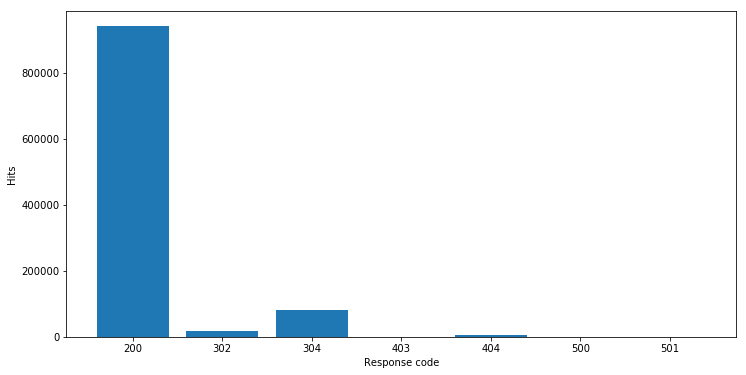

In [13]:
pandas_df = (response_code_counts
             .orderBy('response_code')
             .toPandas())

import numpy as np
from matplotlib import pyplot
%matplotlib inline

fig, ax = pyplot.subplots(figsize=(12, 6))

ax.bar(np.arange(7), pandas_df['count'])

ax.set_xticks(np.arange(7))
ax.set_xticklabels(pandas_df['response_code'])

ax.set_xlabel('Response code')
ax.set_ylabel('Hits')

pass

### (2d) Example: Frequent Hosts

Let's look at hosts that have accessed the server multiple times (e.g., more than ten times). As with the response code analysis in (2b), first we group by host, then we count the size of each group. Finally, we can apply a `.filter()` to return only hosts accessed the correct number of times.

In [14]:
host_more_than_10 = (access_logs
                     .groupBy('host')
                     .count()
                     .filter(func.col('count') > 10))
host_more_than_10.show(truncate=False)

+-------------------------+-----+
|host                     |count|
+-------------------------+-----+
|ird.scitex.com           |13   |
|163.205.166.15           |228  |
|enigma.idirect.com       |276  |
|ppp20.coara.or.jp        |39   |
|128.159.63.129           |12   |
|132.170.244.49           |12   |
|hp165.den.mmc.com        |68   |
|128.159.143.43           |52   |
|lib-golf.tamu.edu        |20   |
|163.205.80.44            |203  |
|dyna-53.bart.nl          |12   |
|164.116.78.80            |29   |
|158.114.228.10           |110  |
|ss4-35.lab.cwu.edu       |19   |
|194.172.75.2             |24   |
|inet01.tuat.ac.jp        |25   |
|134.39.70.204            |94   |
|pipe2.nyc.pipeline.com   |53   |
|ix-atl9-26.ix.netcom.com |25   |
|cse-520b-03.circa.ufl.edu|33   |
+-------------------------+-----+
only showing top 20 rows



In [15]:
Test.assertEquals(host_more_than_10.count(),
                  23656,
                  'incorrect size of host_more_than_10')

1 test passed.


### (2e) Example: Visualizing Endpoints

Now, lets visualize the number of hits to endpoints (URIs) in the log. To perform this task, we once again group and count to get the number of times each endpoint occurs in the logs, then order by descending number of hits. This data can then be plotted with matplotlib:

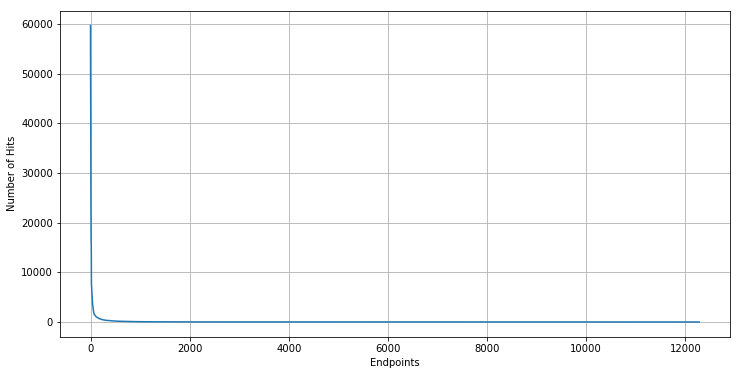

In [16]:
endpoints = (access_logs
             .groupBy('endpoint')
             .count()
             .orderBy('count', ascending=False))

fig, ax = pyplot.subplots(figsize=(12, 6))
ax.plot(endpoints.toPandas()['count'])

ax.set_xlabel('Endpoints')
ax.set_ylabel('Number of Hits')
ax.grid()

pass

### (2f) Example: Top Endpoints

For the final example, we'll look at the top endpoints (URIs) in the log. Since the DataFrame is already ordered by number of hits, we can just print the first ten lines:

In [17]:
print('Top ten endpoints:')
for row in endpoints.head(10):
    print('{} {}'.format(row['endpoint'], row['count']))

Top ten endpoints:
/images/NASA-logosmall.gif 59737
/images/KSC-logosmall.gif 50452
/images/MOSAIC-logosmall.gif 43890
/images/USA-logosmall.gif 43664
/images/WORLD-logosmall.gif 43277
/images/ksclogo-medium.gif 41336
/ksc.html 28582
/history/apollo/images/apollo-logo1.gif 26778
/images/launch-logo.gif 24755
/ 20292


In [18]:
Test.assertEquals([row['endpoint'] for row in endpoints.head(10)],
                  ['/images/NASA-logosmall.gif', 
                   '/images/KSC-logosmall.gif',
                   '/images/MOSAIC-logosmall.gif',
                   '/images/USA-logosmall.gif',
                   '/images/WORLD-logosmall.gif',
                   '/images/ksclogo-medium.gif',
                   '/ksc.html',
                   '/history/apollo/images/apollo-logo1.gif',
                   '/images/launch-logo.gif',
                   '/'],
                  'incorrect top_ten_endpoints')

1 test passed.


## (3) Analyzing Web Server Log File
 
Now it is your turn to perform analyses on web server log files.

### (3a) Exercise: Top Ten Error Endpoints

What are the top ten endpoints which did not have return code 200? Create a sorted list containing top ten endpoints and the number of times that they were accessed with non-200 return code.
 
Think about the steps that you need to perform to determine which endpoints did not have a 200 return code, how you will uniquely count those endpoints, and sort the list.
 
You might want to refer back to the previous Lab (Lab 1 Word Count) for insights.

In [19]:
# TODO: Replace <FILL IN> with appropriate code
# HINT: Each of these <FILL IN> below could be completed with a single transformation or action.
# You are welcome to structure your solution in a different way, so long as
# you ensure the variables used in the next Test section are defined (ie. not_200_counts, top_ten_endpoints_not_200).

not_200 = access_logs.filter(func.col('response_code') != 200)

not_200_counts = not_200.groupBy('endpoint').count()

sorted_not_200 = not_200_counts.orderBy('count', ascending=False)

top_ten_endpoints_not_200 = [row['endpoint'] for row in sorted_not_200.head(10)]

print('Top ten non-200 status endpoints:')
print('\n'.join(top_ten_endpoints_not_200))

Top ten non-200 status endpoints:
/images/NASA-logosmall.gif
/images/KSC-logosmall.gif
/images/MOSAIC-logosmall.gif
/images/USA-logosmall.gif
/images/WORLD-logosmall.gif
/images/ksclogo-medium.gif
/history/apollo/images/apollo-logo1.gif
/images/launch-logo.gif
/
/images/ksclogosmall.gif


In [20]:
# TEST Top ten error endpoints (3a)
Test.assertEquals(not_200_counts.count(), 7689, 'incorrect count for not_200_counts')
Test.assertEquals(top_ten_endpoints_not_200,
                  ['/images/NASA-logosmall.gif',
                   '/images/KSC-logosmall.gif',
                   '/images/MOSAIC-logosmall.gif',
                   '/images/USA-logosmall.gif',
                   '/images/WORLD-logosmall.gif',
                   '/images/ksclogo-medium.gif',
                   '/history/apollo/images/apollo-logo1.gif',
                   '/images/launch-logo.gif',
                   '/',
                   '/images/ksclogosmall.gif'],
                  'incorrect top_ten_endpoints_not_200')

1 test passed.
1 test passed.


### (3b) Exercise: Number of Unique Hosts

How many unique hosts are there in the entire log?
 
Think about the steps that you need to perform to count the number of different hosts in the log.

In [21]:
# TODO: Replace <FILL IN> with appropriate code
# HINT: Do you recall the tips from (3a)? Each of these <FILL IN> could be an transformation or action.

num_hosts = (access_logs
             .select('host')
             .distinct()
             .count())

print('Number of unique hosts: {}'.format(num_hosts))

Number of unique hosts: 54507


In [22]:
# TEST Number of unique hosts (3b)
Test.assertEquals(num_hosts, 54507, 'incorrect num_hosts')

1 test passed.


### (3c) Exercise: Number of Unique Daily Hosts

For an advanced exercise, let's determine the number of unique hosts in the entire log on a day-by-day basis. This computation will give us counts of the number of unique daily hosts. We'd like a list sorted by increasing day of the month which includes the day of the month and the associated number of unique hosts for that day.
 
Think about the steps that you need to perform to count the number of different hosts that make requests *each* day. You may find the [dayofmonth scala function](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.dayofmonth) useful.

*Since the log only covers a single month, you can ignore the month.*

In [23]:
# TODO: Replace <FILL IN> with appropriate code

grouped_by_day = (access_logs
                  .groupBy(func.dayofmonth('date_time').alias('dayofmonth')))

daily_hosts = (grouped_by_day
               .agg(func.countDistinct('host').alias('hosts'))
               .orderBy('dayofmonth'))

daily_hosts.toPandas()

,dayofmonth,hosts
0,1,2582
1,3,2591
2,4,4262
3,5,2573
4,6,2469
5,7,4067
6,8,4259
7,9,4440
8,10,4432
9,11,4507


In [24]:
# TEST Number of unique daily hosts (3c)
Test.assertEquals(daily_hosts.count(), 22, 'incorrect unique_hosts_by_day.count()')
Test.assertEquals(list(tuple(row) for _, row in daily_hosts.toPandas().iterrows()),
                  [(1, 2582), (3, 2591), (4, 4262), (5, 2573), (6, 2469), (7, 4067),
                   (8, 4259), (9, 4440), (10, 4432), (11, 4507), (12, 2865), (13, 2667),
                   (14, 4363), (15, 4334), (16, 4253), (17, 4412), (18, 4231), (19, 2620),
                   (20, 2482), (21, 4125), (22, 4416), (23, 696)],
                  'incorrect daily_hosts')

1 test passed.
1 test passed.


### (3d) Exercise: Visualizing the Number of Unique Daily Hosts

Using the results from the previous exercise, use matplotlib to plot a line graph of the unique hosts requests by day. `.toPandas()` is a useful method for converting a Spark DataFrame to a Pandas DataFrame.

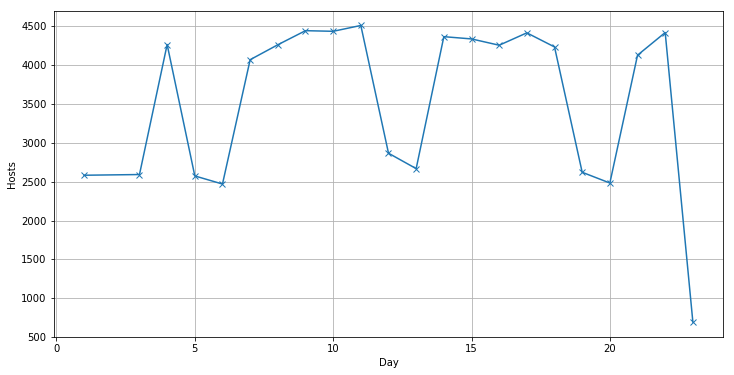

In [25]:
pandas_df = daily_hosts.toPandas()

fig, ax = pyplot.subplots(figsize=(12, 6))
ax.plot(pandas_df[pandas_df.columns[0]],
        pandas_df[pandas_df.columns[1]],
        'x-')

ax.set_xlabel('Day')
ax.set_ylabel('Hosts')
ax.grid()

pass

### (3e) Exercise: Average Number of Daily Requests per Hosts

Next, let's determine the average number of requests on a day-by-day basis. We'd like a list by increasing day of the month and the associated average number of requests per host for that day. Make sure you cache the resulting RDD `avgDailyReqPerHost` so that we can reuse it in the next exercise.

To compute the average number of requests per host, get the total number of request across all hosts and divide that by the number of unique hosts.

*Since the log only covers a single month, you can skip checking for the month. Also, to keep it simple, when calculating the approximate average use the integer value - you do not need to upcast to float*

In [26]:
# TODO: Replace <FILL IN> with appropriate code

daily_host_requests = (access_logs
                       .groupBy(
                           'host',
                           func.dayofmonth('date_time').alias('dayofmonth')
                       )
                       .count())

average_daily_requests_per_host = (daily_host_requests
                                   .groupBy('dayofmonth')
                                   .avg('count')
                                   .orderBy('dayofmonth'))

average_daily_requests_per_host.toPandas()

,dayofmonth,avg(count)
0,1,13.166538
1,3,12.744886
2,4,14.300798
3,5,12.589973
4,6,13.079789
5,7,13.868699
6,8,13.578305
7,9,13.905631
8,10,13.823782
9,11,13.844686


In [27]:
# TEST Average number of daily requests per hosts (3e)
Test.assertEquals(list((row[0], round(row[1], 2)) for _, row in average_daily_requests_per_host.toPandas().iterrows()),
                  [(1.0, 13.17), (3.0, 12.74), (4.0, 14.30), (5.0, 12.59), (6.0, 13.08), (7.0, 13.87),
                   (8.0, 13.58), (9.0, 13.91), (10.0, 13.82), (11.0, 13.84), (12.0, 12.88), (13.0, 13.9),
                   (14.0, 13.59), (15.0, 13.89), (16.0, 13.09), (17.0, 13.42), (18.0, 13.56), (19.0, 12.5),
                   (20.0, 13.03), (21.0, 13.4), (22.0, 12.97), (23.0, 10.89)],
                  'incorrect average_daily_requests_per_host')

1 test passed.


## (4) Exploring 404 Response Codes
 
Let's drill down and explore the error 404 response code records. 404 errors are returned when an endpoint is not found by the server (i.e., a missing page or object).

### (4a) Exercise: Counting 404 Response Codes

Create a DataFrame containing only log records with a 404 response code. Make sure you `cache()` the DataFrame `bad_records` as we will use it in the rest of this exercise.
 
How many 404 records are in the log?

In [28]:
# TODO: Replace <FILL IN> with appropriate code

bad_records = (access_logs
               .filter(func.col('response_code') == 404)
               .cache())

print('Found {} 404 URLs'.format(bad_records.count()))

Found 6185 404 URLs


### (4b) Exercise: Listing 404 Response Code Records

Using the DataFrame containing only log records with a 404 response code that you cached in part (4a), print out a list up to 40 **distinct** endpoints that generate 404 errors -  *no endpoint should appear more than once in your list.*

In [29]:
# TODO: Replace <FILL IN> with appropriate code

bad_unique_endpoints = (bad_records
                        .select('endpoint')
                        .distinct())

bad_unique_endpoints.show(40, truncate=False)

+-------------------------------------------------+
|endpoint                                         |
+-------------------------------------------------+
|/shuttle/missions/sts-68/images/images.html      |
|/history/apollo/a-001/news/                      |
|/history/apollo/a-003/movies/                    |
|/CSMT_PageNS                                     |
|/pub/wiinvn/win3/ww16_99_.zip                    |
|/public.win3/winvn                               |
|/shuttle/sts-1/sts-1-pa.jpg                      |
|/history/apollo/apollo/13                        |
|/shuttle/technology/images/sts-comm-small.gif    |
|/shuttle/missions/sts-71/images/KSC-95EC-0916.txt|
|/shuttle/countdown/ac.html                       |
|/pub/winvn/docs                                  |
|/IMAGES/RSS.GIF                                  |
|/history/apollo/-apollo-13/apollo-3.html         |
|/pub/winvn/readme.txt                            |
|/ksc.shtml                                       |
|/img/sports

### (4c) Exercise: Listing the Top Twenty 404 Response Code Endpoints

Using the DataFrame containing only log records with a 404 response code that you cached in part (4a), print out a list of the top twenty endpoints that generate the most 404 errors.

*Remember, top endpoints should be in sorted order*

In [30]:
bad_endpoints_ranked = (bad_records
                        .groupBy('endpoint')
                        .count()
                        .orderBy('count', ascending=False))

bad_endpoints_ranked.show(20, truncate=False)

+-----------------------------------------------------------------+-----+
|endpoint                                                         |count|
+-----------------------------------------------------------------+-----+
|/pub/winvn/readme.txt                                            |633  |
|/pub/winvn/release.txt                                           |494  |
|/shuttle/missions/STS-69/mission-STS-69.html                     |431  |
|/images/nasa-logo.gif                                            |319  |
|/elv/DELTA/uncons.htm                                            |178  |
|/shuttle/missions/sts-68/ksc-upclose.gif                         |156  |
|/history/apollo/sa-1/sa-1-patch-small.gif                        |146  |
|/images/crawlerway-logo.gif                                      |120  |
|/://spacelink.msfc.nasa.gov                                      |117  |
|/history/apollo/pad-abort-test-1/pad-abort-test-1-patch-small.gif|100  |
|/history/apollo/a-001/a-001-patch-sma

### (4d) Exercise: Listing the Top Twenty-five 404 Response Code Hosts

Instead of looking at the endpoints that generated 404 errors, let's look at the hosts that encountered 404 errors. Using the DataFrame containing only log records with a 404 response code that you cached in part (4a), print out a list of the top twenty-five hosts that generate the most 404 errors.

In [31]:
bad_hosts_ranked = (bad_records
                    .groupBy('host')
                    .count()
                    .orderBy('count', ascending=False))

bad_hosts_ranked.show(25, truncate=False)

+----------------------------+-----+
|host                        |count|
+----------------------------+-----+
|maz3.maz.net                |39   |
|piweba3y.prodigy.com        |39   |
|gate.barr.com               |38   |
|m38-370-9.mit.edu           |37   |
|ts8-1.westwood.ts.ucla.edu  |37   |
|nexus.mlckew.edu.au         |37   |
|204.62.245.32               |33   |
|spica.sci.isas.ac.jp        |27   |
|163.206.104.34              |27   |
|www-d4.proxy.aol.com        |26   |
|www-c4.proxy.aol.com        |25   |
|203.13.168.24               |25   |
|203.13.168.17               |25   |
|internet-gw.watson.ibm.com  |24   |
|scooter.pa-x.dec.com        |23   |
|piweba5y.prodigy.com        |23   |
|crl5.crl.com                |23   |
|onramp2-9.onr.com           |22   |
|slip145-189.ut.nl.ibm.net   |22   |
|198.40.25.102.sap2.artic.edu|21   |
|msp1-16.nas.mr.net          |20   |
|gn2.getnet.com              |20   |
|tigger.nashscene.com        |19   |
|dial055.mbnet.mb.ca         |19   |
|

### (4e) Exercise: Listing 404 Response Codes per Day

Let's explore the 404 records temporally. Break down the 404 requests by day and get the daily counts sorted by day as a list.

*Since the log only covers a single month, you can ignore the month in your checks.*

In [32]:
bad_records_per_day = (bad_records
                       .groupBy(func.dayofmonth('date_time').alias('dayofmonth'))
                       .count()
                       .orderBy('dayofmonth'))

bad_records_per_day.show(30)

+----------+-----+
|dayofmonth|count|
+----------+-----+
|         1|  243|
|         3|  221|
|         4|  373|
|         5|  240|
|         6|  390|
|         7|  517|
|         8|  344|
|         9|  320|
|        10|  294|
|        11|  298|
|        12|  170|
|        13|  210|
|        14|  307|
|        15|  322|
|        16|  255|
|        17|  262|
|        18|  260|
|        19|  224|
|        20|  292|
|        21|  308|
|        22|  256|
|        23|   79|
+----------+-----+



### (4f) Exercise: Visualizing the 404 Response Codes by Day

Using the results from the previous exercise, use `matplotlib` to plot a "Line" or "Bar" graph of the 404 response codes by day.

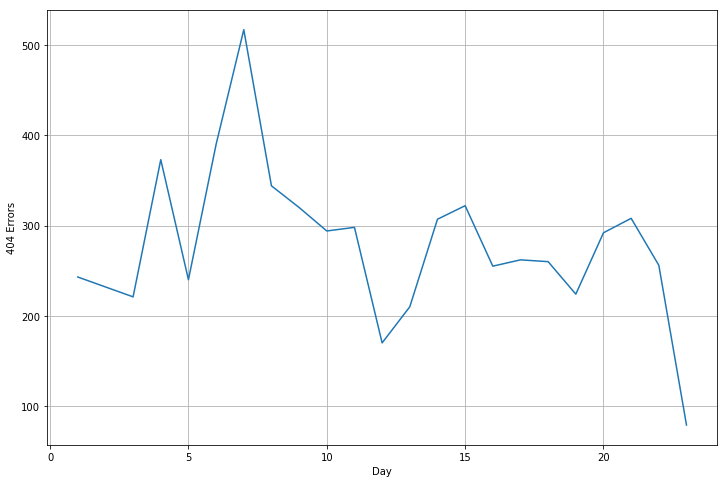

In [33]:
pandas_df = bad_records_per_day.toPandas()

fig, ax = pyplot.subplots(figsize=(12, 8))

ax.plot(pandas_df['dayofmonth'], pandas_df['count'])

ax.set_xlabel('Day')
ax.set_ylabel('404 Errors')
ax.grid()
pass

### (4g) Exercise: Hourly 404 Response Codes

Using the DataFrame `bad_records` you cached in the part (4a) and by hour of the day and in increasing order, create a DataFrame containing how many requests had a 404 return code for each hour of the day (midnight starts at 0).

In [34]:
bad_records_by_hour = (bad_records
                       .groupBy(func.hour('date_time').alias('hour'))
                       .count()
                       .orderBy('hour'))

bad_records_by_hour.show(24)

+----+-----+
|hour|count|
+----+-----+
|   0|  270|
|   1|  241|
|   2|  234|
|   3|  272|
|   4|  175|
|   5|  171|
|   6|  422|
|   7|  272|
|   8|  102|
|   9|   95|
|  10|   93|
|  11|  122|
|  12|  199|
|  13|  185|
|  14|  329|
|  15|  263|
|  16|  438|
|  17|  397|
|  18|  318|
|  19|  347|
|  20|  373|
|  21|  330|
|  22|  268|
|  23|  269|
+----+-----+



### (4h) Exercise: Visualizing the 404 Response Codes by Hour

Using the results from the previous exercise, use `matplotlib` to plot a "Line" or "Bar" graph of the 404 response codes by hour.

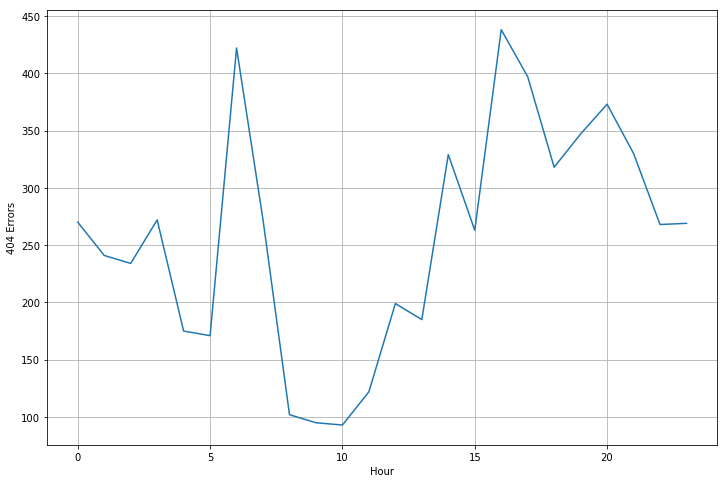

In [35]:
pandas_df = bad_records_by_hour.toPandas()

fig, ax = pyplot.subplots(figsize=(12, 8))

ax.plot(pandas_df['hour'], pandas_df['count'])

ax.set_xlabel('Hour')
ax.set_ylabel('404 Errors')
ax.grid()
pass